In [1]:
#|default_exp augment

# Augmentation

In [2]:
#|export
import torch
import random
import fastcore.all as fc

from torch import nn
from torch.nn import init

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import * 
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *

In [3]:
import torch.nn.functional as F
from functools import partial
import matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor, optim
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset
from fastcore.test import test_close
import torchvision.transforms.functional as TF

import logging; logging.disable(logging.WARNING)
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['image.cmap'] = 'gray_r'


In [4]:
xl, yl = 'image', 'label'
name = "fashion_mnist"
bs = 1024
xmean, xstd = 0.29, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o) - xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs=bs, num_workers=4)

  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralReLU, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
set_seed(42)

In [6]:
def get_model(act=GeneralReLU, nfs=(16, 32, 64, 128, 256, 512), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]

    return nn.Sequential(*layers)

In [7]:
lr, epochs = 1e-2, 5
tmax = epochs * len(dls.train)
sched = partial(optim.lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)

lr_find_cbs = [DeviceCB()]
cbs = [metrics, astats, ProgressCB(plot=True), BatchSchedCB(sched)]
learn = Learner(get_model(act_gr).apply(iw), dls, F.cross_entropy, lr=lr, cbs=lr_find_cbs, opt_func=optim.AdamW)

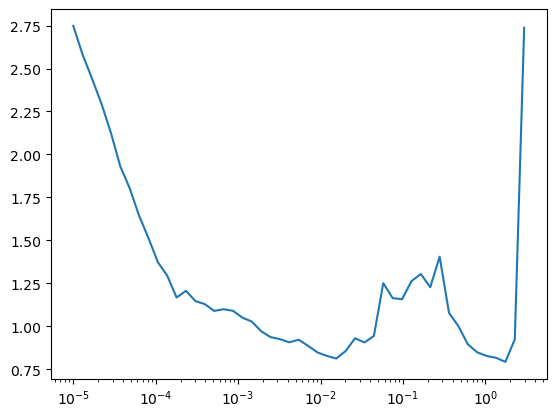

In [8]:
learn.lr_find()

accuracy,loss,epoch,train
0.100,2.911,0,train
0.100,2.841,0,valid


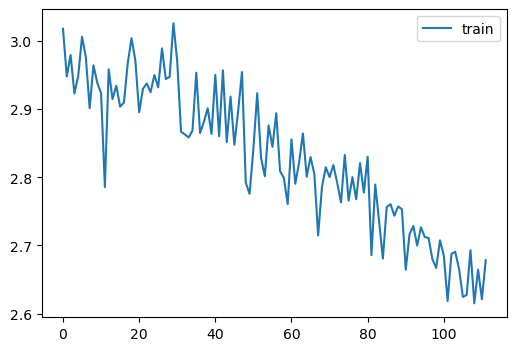

In [10]:
learn.fit(epochs, lr=1e-2, cbs=cbs)

## Pooling

In [8]:
class GlobalAvgPool(nn.Module):
    def forward(self, x): return x.mean((-2, -1))

In [9]:
def get_model2(act=partial(GeneralReLU, leak=0.1, sub=0.4), nfs=(16, 32, 64, 128, 256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs) -1)]
    layers += [ResBlock(256, 512, act=act, norm=norm), GlobalAvgPool()]
    layers += [nn.Linear(512, 10, bias=True), nn.BatchNorm1d(10), nn.Softmax(dim=1)]
    return nn.Sequential(*layers)

In [10]:
#| export
def _flops(x, h, w):
    if x.dim() <= 3: return x.numel()
    if x.dim() == 4: return x.numel()*h*w

@fc.patch
def summary(self:Learner, isleaf=fc.risinstance(ResBlock)):
    res = '|Module|Input|Output|Num params|MFlops|\n|--|--|--|--|--|\n'
    totp, totf = 0, 0
    @hook
    def _f(hook, model, inp, out):
        nonlocal res, totp, totf
        num_params = sum(o.numel() for o in model.parameters())
        totp += num_params
        *_, h, w = out.shape
        flops = sum(_flops(o, h, w) for o in model.parameters())/1e6
        totf += flops
        res += f'|{type(model).__name__}|{tuple(inp[0].shape)}|{tuple(out.shape)}|{num_params}|{flops:.1f}|\n'
    
    with Hooks(*model_iter(self.model, isleaf=isleaf), h=_f) as h: self.fit(1, lr=0, cbs=SingleBatchCB())
    print(f"Total params: {totp} - Mflops: {totf:.1f}")
    
    if fc.IN_NOTEBOOK:
        from IPython.display import Markdown
        return Markdown(res)
    else: print(res)        

In [11]:
lr_find_cbs = [DeviceCB()]
cbs = [metrics, astats, ProgressCB(plot=True), BatchSchedCB(sched)]
learn = Learner(get_model2(act_gr).apply(iw), dls, F.cross_entropy, cbs=lr_find_cbs,
                opt_func=optim.AdamW)

In [22]:
learn.summary()

In [23]:
learn.lr_find()

accuracy,loss,epoch,train
0.817,1.814,0,train
0.832,1.696,0,valid
0.886,1.652,1,train
0.883,1.617,1,valid
0.903,1.592,2,train
0.890,1.595,2,valid
0.922,1.561,3,train
0.910,1.572,3,valid
0.939,1.542,4,train
0.918,1.561,4,valid


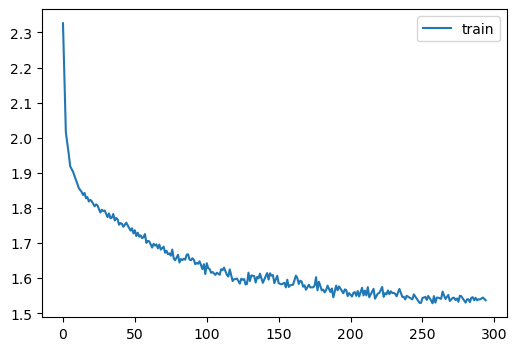

In [25]:
learn.fit(epochs, lr=6e-2, cbs=cbs)

In [12]:
def get_model3(act=partial(GeneralReLU, leak=0.1, sub=0.4), nfs=(16, 32, 64, 128, 256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]    
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [GlobalAvgPool(), nn.Linear(256, 10, bias=False), nn.BatchNorm1d(10)]    
    return nn.Sequential(*layers)


In [13]:
learn = Learner(get_model3(act_gr).apply(iw), dls, F.cross_entropy, lr=lr, 
                cbs=lr_find_cbs,
                opt_func=optim.AdamW)

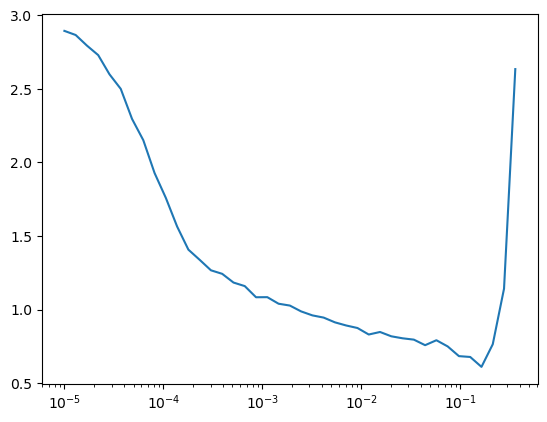

In [19]:
learn.lr_find()

In [26]:
learn.summary()

Total params: 4907598 - Mflops: 33.0


|Module|Input|Output|Num params|MFlops|
|--|--|--|--|--|
|ResBlock|(1024, 1, 28, 28)|(1024, 16, 28, 28)|6928|5.3|
|ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14560|2.8|
|ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57792|2.8|
|ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|230272|3.7|
|ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|919296|3.7|
|ResBlock|(1024, 256, 2, 2)|(1024, 512, 2, 2)|3673600|14.7|
|GlobalAvgPool|(1024, 512, 2, 2)|(1024, 512)|0|0.0|
|Linear|(1024, 512)|(1024, 10)|5130|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|
|Softmax|(1024, 10)|(1024, 10)|0|0.0|


accuracy,loss,epoch,train
0.808,0.766,0,train
0.866,0.470,0,eval
0.897,0.394,1,train
0.890,0.350,1,eval
0.921,0.270,2,train
0.914,0.293,2,eval
0.942,0.200,3,train
0.921,0.250,3,eval
0.962,0.147,4,train
0.929,0.233,4,eval


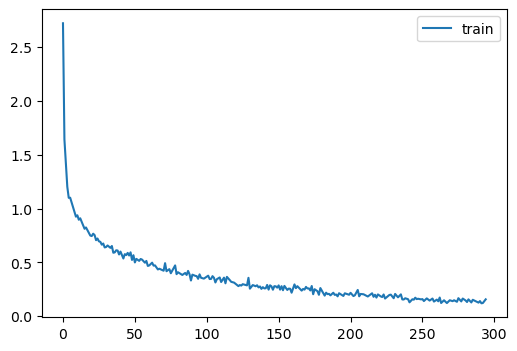

In [24]:
learn.fit(epochs, lr=8e-2, cbs=cbs)

In [14]:
def get_model4(act=nn.ReLU, nfs=(16, 32, 64, 128, 256), norm=nn.BatchNorm2d):
    layers = [conv(1, 16, ks=5, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [GlobalAvgPool(), nn.Linear(256, 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [15]:
learn = Learner(get_model4(act_gr).apply(iw), dls, F.cross_entropy, cbs=lr_find_cbs, opt_func=optim.AdamW)

In [20]:
learn.summary()

Total params: 1224948 - Mflops: 2.8


|Module|Input|Output|Num params|MFlops|
|--|--|--|--|--|
|Conv2d|(1024, 1, 28, 28)|(1024, 16, 10, 10)|416|0.0|
|BatchNorm2d|(1024, 16, 10, 10)|(1024, 16, 10, 10)|32|0.0|
|GeneralReLU|(1024, 16, 10, 10)|(1024, 16, 10, 10)|0|0.0|
|ResBlock|(1024, 16, 10, 10)|(1024, 32, 5, 5)|14560|0.4|
|ResBlock|(1024, 32, 5, 5)|(1024, 64, 3, 3)|57792|0.5|
|ResBlock|(1024, 64, 3, 3)|(1024, 128, 2, 2)|230272|0.9|
|ResBlock|(1024, 128, 2, 2)|(1024, 256, 1, 1)|919296|0.9|
|GlobalAvgPool|(1024, 256, 1, 1)|(1024, 256)|0|0.0|
|Linear|(1024, 256)|(1024, 10)|2560|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


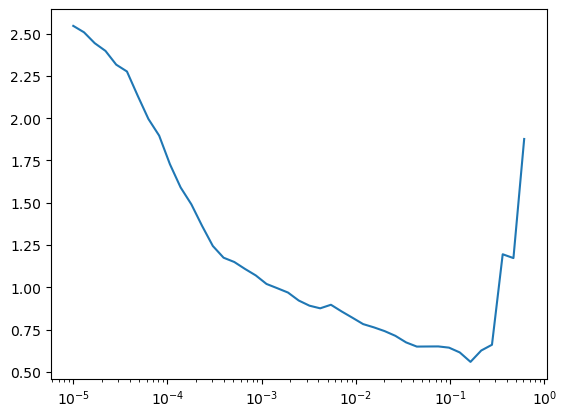

In [35]:
learn.lr_find()

In [16]:
conf = Config(
    ds="fashion_mnist", 
    arch="Conv[1,16]ResNet[16, 32, 64, 128, 256]",
    epochs=20,
    lr=2e-1)

In [17]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralReLU))
wand = WandBCB(conf)
progress = ProgressCB(plot=True)
sched = BatchSchedCB(partial(
    optim.lr_scheduler.OneCycleLR,
    max_lr=conf.lr, 
    total_steps=conf.epochs*len(dls.train)))

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: leourbina. Use `wandb login --relogin` to force relogin


accuracy,loss,epoch,train
0.819,0.649,0,train
0.838,0.508,0,valid
0.878,0.357,1,train
0.850,0.477,1,valid
0.882,0.332,2,train
0.850,0.476,2,valid
0.882,0.321,3,train
0.867,0.429,3,valid
0.887,0.310,4,train
0.869,0.363,4,valid


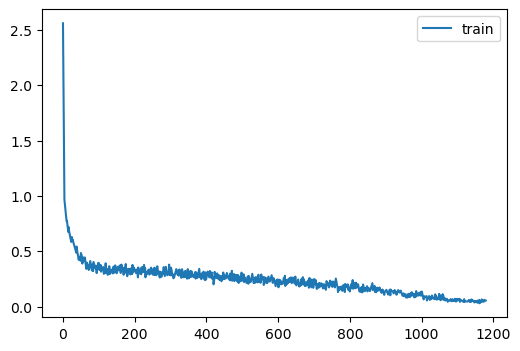

train/accuracy,▁▃▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇██
train/loss,█▇▅▄▄▄▄▄▄▄▄▃▄▃▃▄▃▃▃▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁
valid/accuracy,▁▂▂▃▄▅▃▅▄▆▆▆▇▆▇▇████
valid/loss,██▇▇█▇▆▆▄▄▄▃▄▄▃▃▄▃▂▂▄▂▄▂▂▁▃▂▃▂▃▂▃▁▃▂▃▂▃▂
train/accuracy,0.98567
train/loss,0.04873
valid/accuracy,0.92
valid/loss,0.27059


In [18]:
learn.fit(conf.epochs, lr=conf.lr, cbs=[metrics, astats, wand, progress, sched])

# Data augmentation

In [18]:
from torchvision import transforms

In [19]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y=fc.noop):
    return tfm_x(b[0]), tfm_y(b[1])

tfms = nn.Sequential(transforms.RandomCrop(28, padding=4),
                    transforms.RandomHorizontalFlip())

augcb = BatchTfmCB(partial(tfm_batch, tfm_x=tfms), on_val=False)
model = get_model()
learn = Learner(model, dls, F.cross_entropy, lr=lr, cbs=[DeviceCB(), SingleBatchCB(), augcb])

In [20]:
learn.fit(1)

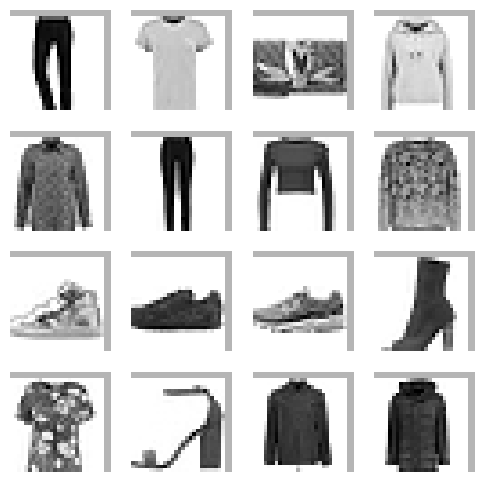

In [21]:
xb, yb = learn.batch
show_images(xb[:16], imsize=1.5)

In [24]:
#| export
@fc.patch
@fc.delegates(show_images)
def show_image_batch(self: Learner, max_n=9, cbs=None, **kwargs):
    self.fit(1, cbs=[SingleBatchCB()] + fc.L(cbs))
    show_images(self.batch[0][:max_n], **kwargs)

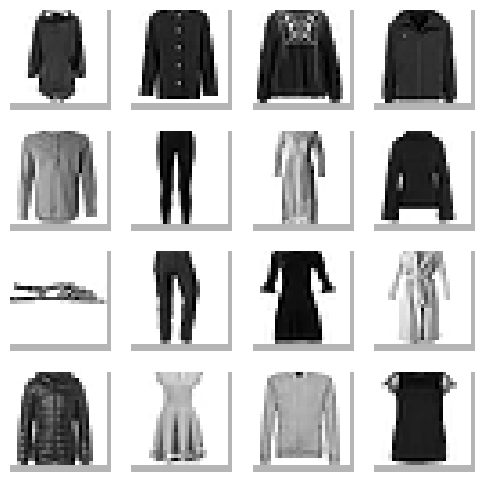

In [25]:
learn.show_image_batch(max_n=16, imsize=1.5)

In [26]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1, padding_mode='circular'),
                    transforms.RandomHorizontalFlip())
augcb = BatchTfmCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

In [137]:
conf = Config("fashion_mnist", "ResNet+Aug+Dropout", 
              lr=1e-2, epochs=20, dropout=0.3)

In [138]:
def get_model5(act=GeneralReLU, nfs=(16, 32, 64, 128, 256, 512), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Dropout(conf.dropout), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]

    return nn.Sequential(*layers)

In [139]:
set_seed(42)
sched = BatchSchedCB(partial(
    optim.lr_scheduler.OneCycleLR,
    max_lr=conf.lr, 
    total_steps=conf.epochs*len(dls.train)))
wand = WandBCB(conf)
astats = ActivationStats(fc.risinstance(GeneralReLU))
model = get_model5(act_gr, norm=nn.BatchNorm2d).apply(iw)
cbs = [wand, astats, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=conf.lr, opt_func=optim.AdamW,
                cbs=[DeviceCB(), metrics])

In [140]:
learn.summary()

Total params: 4903620 - Mflops: 22.0


|Module|Input|Output|Num params|MFlops|
|--|--|--|--|--|
|ResBlock|(1024, 1, 28, 28)|(1024, 16, 28, 28)|6928|5.3|
|ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14432|2.8|
|ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57536|2.8|
|ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|229760|3.7|
|ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|918272|3.7|
|ResBlock|(1024, 256, 2, 2)|(1024, 512, 1, 1)|3671552|3.7|
|Flatten|(1024, 512, 1, 1)|(1024, 512)|0|0.0|
|Dropout|(1024, 512)|(1024, 512)|0|0.0|
|Linear|(1024, 512)|(1024, 10)|5120|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


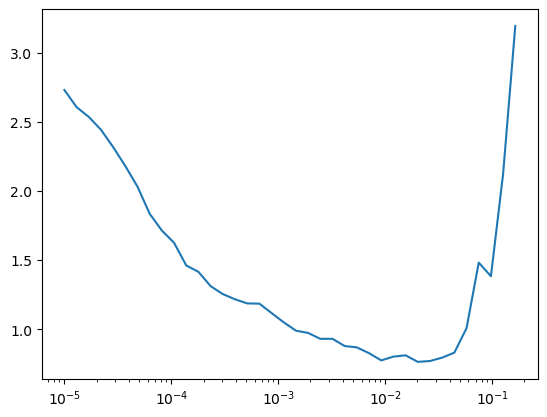

In [141]:
learn.lr_find()

accuracy,loss,epoch,train
0.731,0.771,0,train
0.793,0.710,0,valid
0.845,0.438,1,train
0.854,0.484,1,valid
0.879,0.340,2,train
0.876,0.343,2,valid
0.894,0.296,3,train
0.882,0.343,3,valid
0.906,0.263,4,train
0.900,0.282,4,valid


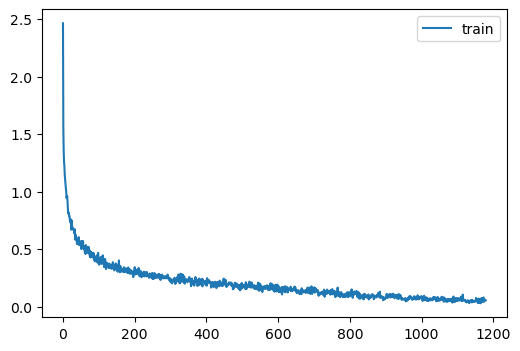

train/accuracy,▁▄▅▆▆▆▆▆▇▇▇▇▇▇██████
train/loss,█▇▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
valid/accuracy,▁▄▅▆▇▇▇▇▇█▇█████████
valid/loss,██▅▅▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▂▁▂▁▃▁▃▁▂▁▃▂▃▂▃▂▃▂
train/accuracy,0.98345
train/loss,0.04901
valid/accuracy,0.9194
valid/loss,0.29714


In [142]:
learn.fit(conf.epochs, cbs=cbs)

In [128]:
from pathlib import Path
mdl_path = Path('models')
mdl_path.mkdir(exist_ok=True)

In [ ]:
torch.save(learn.model, mdl_path/'data_aug.pkl')

In [129]:
model = torch.load(mdl_path/'data_aug.pkl')

## Test time augmentation (TTA)

In [143]:
#| export
class CapturePreds(Callback):
    def before_fit(self, learn): self.all_inputs, self.all_preds, self.all_targs = [], [], []
    def after_batch(self, learn: Learner): 
        self.all_inputs.append(to_cpu(learn.batch[0]))
        self.all_preds.append(to_cpu(learn.preds))
        self.all_targs.append(to_cpu(learn.batch[1]))
    def after_fit(self, learn: Learner):
        self.all_preds, self.all_targs, self.all_inputs = map(torch.cat, [self.all_preds, self.all_targs, self.all_inputs])

In [144]:
#| export
@fc.patch
def capture_preds(self: Learner, cbs=None, inputs=False):
    cp = CapturePreds()
    self.fit(1, train=False, cbs=[cp] + fc.L(cbs))
    res = cp.all_preds, cp.all_targs
    if inputs: res = res + (cp.all_inputs,)
    return res

In [145]:
ap1, at = learn.capture_preds(cbs=[ProgressCB()])

accuracy,loss,epoch,train
0.919,0.297,0,valid


In [146]:
ttacb = BatchTfmCB(partial(tfm_batch, tfm_x=TF.hflip), on_val=True)
ap2, at = learn.capture_preds(cbs=[ProgressCB(), ttacb])

accuracy,loss,epoch,train
0.688,2.113,0,valid


In [147]:
ap1.shape, ap2.shape, at.shape

(torch.Size([10000, 10]), torch.Size([10000, 10]), torch.Size([10000]))

In [151]:
ap = torch.stack([ap1, ap2]).mean(0).argmax(1) # Make the predictions be the average of the two

In [155]:
round((ap==at).float().mean().item(), 3) 

0.862

Well that kinda sucks...

## Random erase

In [178]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]

In [179]:
xm, xs = xbt.mean(), xbt.std()
xm, xs

(tensor(-0.06), tensor(0.98))

In [180]:
xbt.min(), xbt.max()

(tensor(-0.83), tensor(2.03))

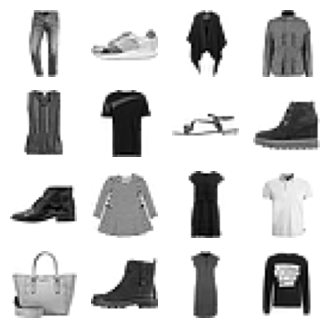

In [181]:
show_images(xbt, imsize=1)

In [182]:
pct = 0.2

In [183]:
xbt.shape

torch.Size([16, 1, 28, 28])

In [184]:
szx = int(xbt.shape[-2]*pct)
szy = int(xbt.shape[-1]*pct)

In [185]:
stx = int(random.random()*(1-pct)*xbt.shape[-2])
sty = int(random.random()*(1-pct)*xbt.shape[-1])

In [186]:
szx, szy, stx, sty

(5, 5, 15, 19)

In [187]:
init.normal_(xbt[:,:, stx:stx+szx, sty:sty+szy], mean=xm, std=xs);

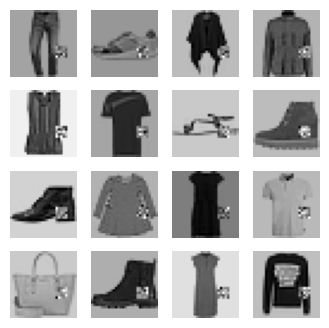

In [188]:
show_images(xbt, imsize=1)

In [189]:
xbt.min(), xbt.max()

(tensor(-3.77), tensor(3.66))

In [200]:
#|export
def _rand_erase1(x, pct, xm, xs, mn, mx):
    szx = int(xbt.shape[-2]*pct)
    szy = int(xbt.shape[-1]*pct)
    stx = int(random.random()*(1-pct)*xbt.shape[-2])
    sty = int(random.random()*(1-pct)*xbt.shape[-1])
    init.normal_(x[:,:, stx:stx+szx, sty:sty+szy], mean=xm, std=xs)
    x.clamp_(mn, mx)

In [201]:
xb, _ = next(iter(dls.train))
xb.mean(), xb.std(), xb.min(), xb.max()

(tensor(-0.01), tensor(1.01), tensor(-0.83), tensor(2.03))

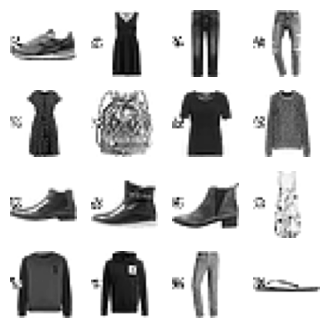

In [202]:
_rand_erase1(xb, 0.2, xb.mean(), xb.std(), xb.min(), xb.max())
show_images(xb[:16], imsize=1)

In [203]:
xb.mean(), xb.std(), xb.min(), xb.max()

(tensor(0.01), tensor(1.01), tensor(-0.83), tensor(2.03))

In [216]:
#|export
def rand_erase(x, pct=0.2, max_num=5):
    xm, xs, mn, mx = x.mean(), x.std(), x.min(), x.max()
    num = random.randint(0, max_num)
    for i in range(num): _rand_erase1(x, pct, xm, xs, mn, mx)
    return x
    
class RandErase(nn.Module):
    def __init__(self, pct=0.2, max_num=5):
        super().__init__()
        self.pct, self.max_num = pct, max_num
    
    def forward(self, x): return rand_erase(x, self.pct, self.max_num)

In [217]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                    transforms.RandomHorizontalFlip(),
                    RandErase())
augcb = BatchTfmCB(partial(tfm_batch, tfm_x=tfms), on_val=True)

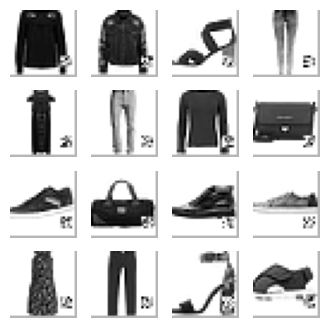

In [218]:
model = get_model5()
learn = Learner(model, dls, F.cross_entropy, lr=conf.lr, cbs=[DeviceCB(), SingleBatchCB(), augcb])
learn.fit(1)
xb, yb = learn.batch
show_images(xb[:16], imsize=1)

train/loss,█▆▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▂▁▁▂▁▁▁▁▁▁
valid/loss,▃█▃▂▇▂▇▁▇▃
train/loss,0.60247
valid/loss,0.73981


accuracy,loss,epoch,train
0.724,0.990,0,train
0.769,0.790,0,valid
0.816,0.723,1,train
0.814,0.673,1,valid
0.841,0.630,2,train
0.837,0.597,2,valid
0.852,0.573,3,train
0.832,0.581,3,valid
0.862,0.507,4,train
0.845,0.478,4,valid


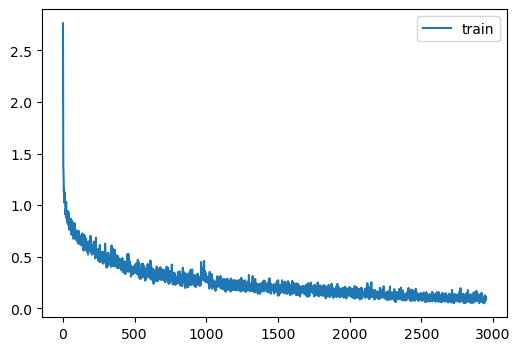

train/accuracy,▁▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
train/loss,█▆▆▅▅▄▄▃▃▃▃▃▃▃▃▃▂▃▂▂▂▃▂▃▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁
valid/accuracy,▁▃▄▄▃▅▅▅▆▆▅▆▆▆▇▆▇▅▇▇▇▇▇▇▇▇█▇▇███████████
valid/loss,██▅▆▇▄▄▅▃▃▃▃▄▃▂▃▂▃▃▃▂▂▂▂▁▂▂▁▂▂▁▂▂▁▂▁▁▂▁▁
train/accuracy,0.96798
train/loss,0.0919
valid/accuracy,0.9381
valid/loss,0.19396


In [223]:
conf['epochs'] = 50
tmax = conf.epochs * len(dls.train)
sched = partial(optim.lr_scheduler.OneCycleLR, max_lr=conf.lr, total_steps=tmax)
cbs = [DeviceCB(), wand, metrics, ProgressCB(plot=True), astats, BatchSchedCB(sched), augcb]
model = get_model5(act_gr).apply(iw)
learn = Learner(model, dls, F.cross_entropy, lr=conf.lr, cbs=cbs, opt_func=optim.AdamW)
learn.fit(conf.epochs)

## Random copy

In [225]:
xb, _ = next(iter(dls.train))
xbt = xb[:16]

In [ ]:
szx = int(xbt.shape[-2]*pct)
szy = int(xbt.shape[-1]*pct)
stx1 = int(random.random()*(1-pct)*xbt.shape[-2])
sty1 = int(random.random()*(1-pct))

In [3]:
import nbdev; nbdev.nbdev_export() 